#+TITLE: Weight Pruning
#+CATEGORIES: compression regularization
#+DESCRIPTION: Pruning is used to reduce the complexity and size of a model by removing weights or neurons. Pruning methods typically select weights to prune according to importance heuristics like magnitude or gradient saliency. However, even random pruning has been shown to produce accurate models at significant levels of sparsity. While pruning can cause some loss in model accuracy, this can be mitigated by fine-tuning the pruned model on the original dataset.
#+DATE: 2020-01-02
#+HERO: /static/space-bg.png

# Overview

Pruning is used to reduce the complexity and size of a model by removing weights or neurons. Pruning methods typically select weights to prune according to importance heuristics like magnitude or gradient saliency. However, even random pruning has been shown to produce accurate models at significant levels of sparsity. While pruning can cause some loss in model accuracy, this can be mitigated by fine-tuning the pruned model on the original dataset.

In [126]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune

In [127]:
class LeNet(nn.Module):
    def __init__(self, in_channels=1, n_outputs=10):
        super(LeNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(16*3*3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
model = LeNet()

In [128]:
# Shape of the weights
print(model.conv1.weight.shape)

# Weights for the first convolutional filter
print(model.conv1.weight[0])

torch.Size([8, 1, 3, 3])
tensor([[[ 0.2198, -0.2798, -0.0328],
         [ 0.2983,  0.2103, -0.0328],
         [-0.2682,  0.0169,  0.2760]]], grad_fn=<SelectBackward0>)


We can visualize each of the filter weights for a whole layer with matshow.

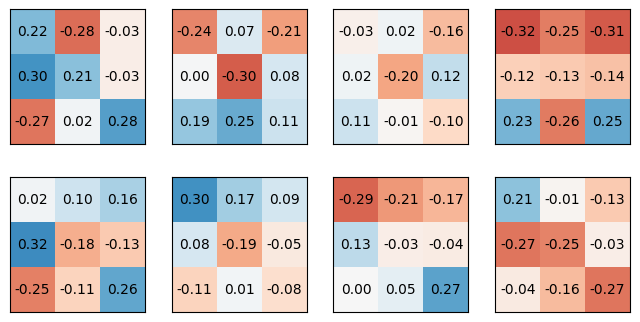

In [129]:
def plot_filters(weights, num_cols=4):
    weights = weights.detach().numpy()
    num_filters = weights.shape[0]
    num_rows = int(num_filters / num_cols)
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols*2,num_rows*2))

    for i in range(num_filters):
        axs[int(i / num_cols), i % num_cols].matshow(weights[i, 0, :, :], cmap="RdBu", vmin=-0.5, vmax=0.5)
        axs[int(i / num_cols), i % num_cols].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        for (j,k), w in np.ndenumerate(weights[i, 0, :, :]):
            axs[int(i / num_cols), i % num_cols].text(k, j, format(w, "0.2f"), ha="center", va="center")
        
plot_filters(model.conv1.weight)

We can then prune the weights with any number of different pytorch strategies. The granularity of the pruning method can be unstructured or structured, where unstructured methods refer to weight-level or connection-level masking and structured methods refer to neuron-level, channel-level, or layer-level masking. Removing entire rows, columns, or blocks from a layer's weight matrix can be effective at reducing computational complexity as the reduced size of the weight matrix can be leveraged for hardware optimizations. This is more difficult to achieve with the sparse matrices resulting from unstructured masking. However, unstructured masking tends to result in networks with better generalization as the number of masked parameters increases.

\begin{align}
\hat{W}_{uns} &= \begin{bmatrix}
w_{11} & w_{12} & 0 & w_{14} \\
0 & w_{22} & 0 & 0 \\
w_{31} & 0 & 0 & w_{34} \\
0 & 0 & w_{43} & w_{44}
\end{bmatrix} \\[0.1in]
\hat{W}_{str} &= \begin{bmatrix}
w_{11} & w_{12} & w_{13} & w_{14} \\
0 & 0 & 0 & 0 \\
w_{31} & w_{32} & w_{33} & w_{34} \\
0 & 0 & 0 & 0
\end{bmatrix}
\end{align}

In [130]:
prune.random_unstructured(model.conv1, name="weight", amount=0.5)

Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))

Pruning in PyTorch works by adding some additional computation into the given module. The original weight matrix is copied over to a new parameter named weight_orig. The pruned subnetwork is represented with a binary weight_mask where a value of 1 means that the given parameter is retained. This element wise product is applied automatically when calling module.weight thanks to an additional forward_hook.

In [131]:
print(model.conv1.weight_orig[0])
print(model.conv1.weight_mask[0])
print(model.conv1.weight[0])

tensor([[[ 0.2198, -0.2798, -0.0328],
         [ 0.2983,  0.2103, -0.0328],
         [-0.2682,  0.0169,  0.2760]]], grad_fn=<SelectBackward0>)
tensor([[[0., 0., 0.],
         [0., 1., 1.],
         [1., 0., 1.]]])
tensor([[[ 0.0000, -0.0000, -0.0000],
         [ 0.0000,  0.2103, -0.0328],
         [-0.2682,  0.0000,  0.2760]]], grad_fn=<SelectBackward0>)


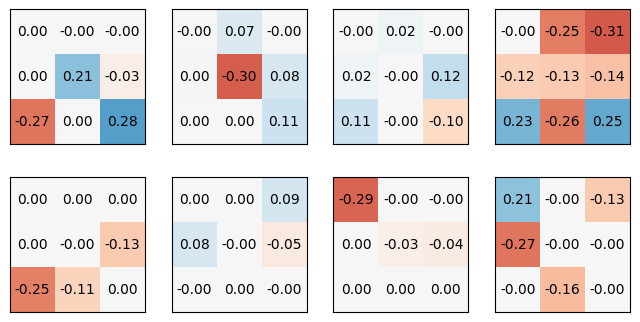

In [132]:
plot_filters(model.conv1.weight)

Now let's reset the pruned module and demonstrate how structured methods operate over different dimensions.

In [133]:
def reset_pruning(module):
    module.weight_mask = torch.ones(module.weight.shape)
    prune.remove(module, name="weight")

reset_pruning(model.conv1)

In [134]:
print(model.conv1.weight[0])

tensor([[[ 0.2198, -0.2798, -0.0328],
         [ 0.2983,  0.2103, -0.0328],
         [-0.2682,  0.0169,  0.2760]]], grad_fn=<SelectBackward0>)


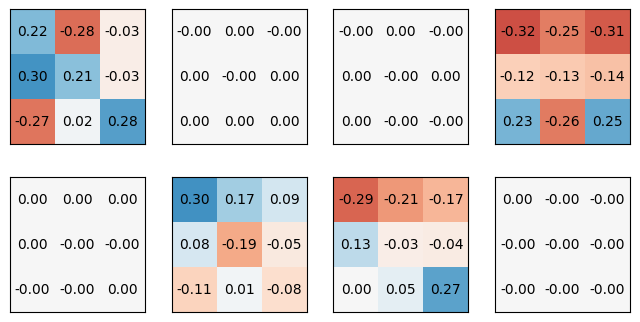

In [135]:
# Prune entire filters
prune.random_structured(model.conv1, name="weight", amount=0.5, dim=0)
plot_filters(model.conv1.weight)
reset_pruning(model.conv1)

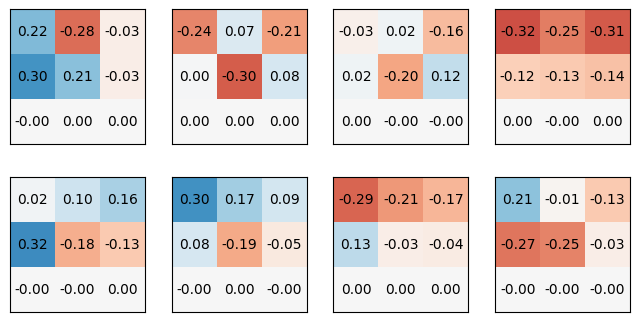

In [136]:
# Prune rows
prune.random_structured(model.conv1, name="weight", amount=0.3, dim=2)
plot_filters(model.conv1.weight)
reset_pruning(model.conv1)

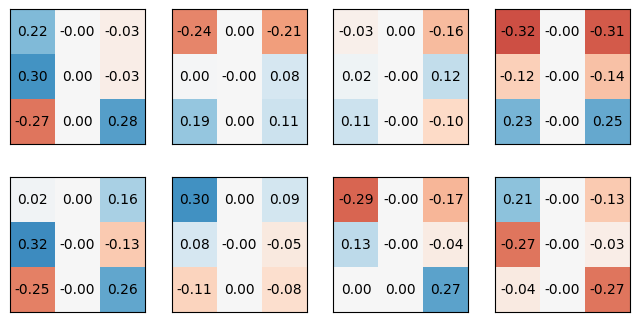

In [137]:
# Prune columns
prune.random_structured(model.conv1, name="weight", amount=0.3, dim=3)
plot_filters(model.conv1.weight)
reset_pruning(model.conv1)